In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import plot_tree
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.tree import _tree
from sklearn.inspection import partial_dependence

# Load mushroom dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
data = pd.read_csv(url, header=None)
# Set column names for the dataset
data.columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]


In [2]:
# Drop duplicates from the 'class' column (not modifying the DataFrame in-place)
data['class'].drop_duplicates()

0    p
1    e
Name: class, dtype: object

In [3]:
# Encode 'class' column with LabelEncoder
le = LabelEncoder()
le.fit(data['class'].drop_duplicates().array)
le.classes_
data['class'] = le.transform(data['class'])

In [4]:
# Convert categorical columns to numerical codes
for col in data.columns:
    data[col] = pd.Categorical(data[col]).codes


In [5]:
# Split the data into training and testing sets
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## TREE



In [6]:
# Build a Decision Tree model
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=2)
clf = clf.fit(X_train, y_train)


[Text(0.4, 0.8333333333333334, 'x[8] <= 0.5\nentropy = 0.999\nsamples = 6499\nvalue = [3365, 3134]'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 1398\nvalue = [0, 1398]'),
 Text(0.6, 0.5, 'x[19] <= 1.5\nentropy = 0.925\nsamples = 5101\nvalue = [3365, 1736]'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.321\nsamples = 1334\nvalue = [78, 1256]'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.55\nsamples = 3767\nvalue = [3287, 480]')]

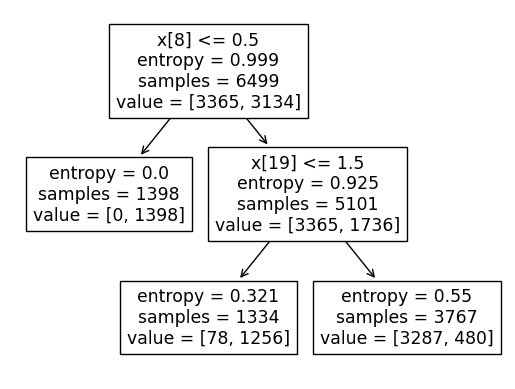

In [7]:
#Print tree plot
tree.plot_tree(clf)

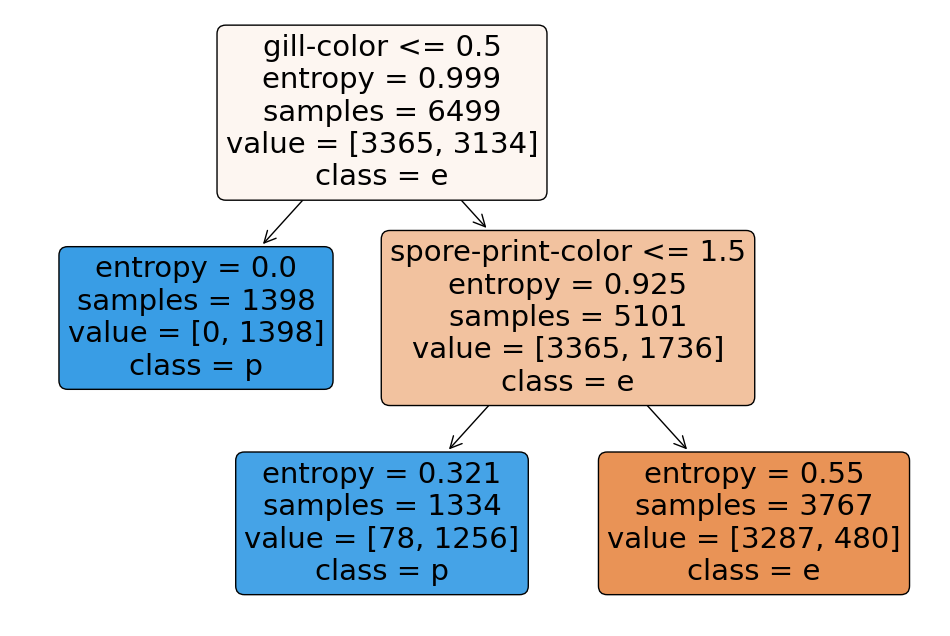

In [8]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=X.columns, class_names=le.classes_, filled=True, rounded=True)
plt.show()

In [9]:
# Make predictions and print the result
result = clf.predict(X_test.iloc[:1])
predicted_class = le.inverse_transform(result)
print(f"Predicted class for the first test sample: {predicted_class}")


Predicted class for the first test sample: ['e']


In [10]:
# Evaluate the model with confusion matrix
y_result = clf.predict(X_test)
cm = confusion_matrix(y_result, y_test)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[825 124]
 [ 18 658]]


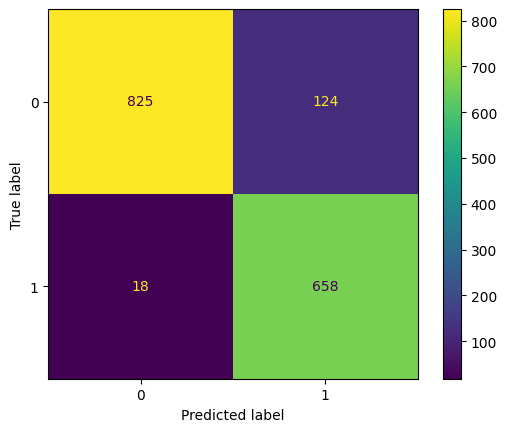

In [11]:
# Confusion matrix plot
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp_tree.plot()
plt.show()

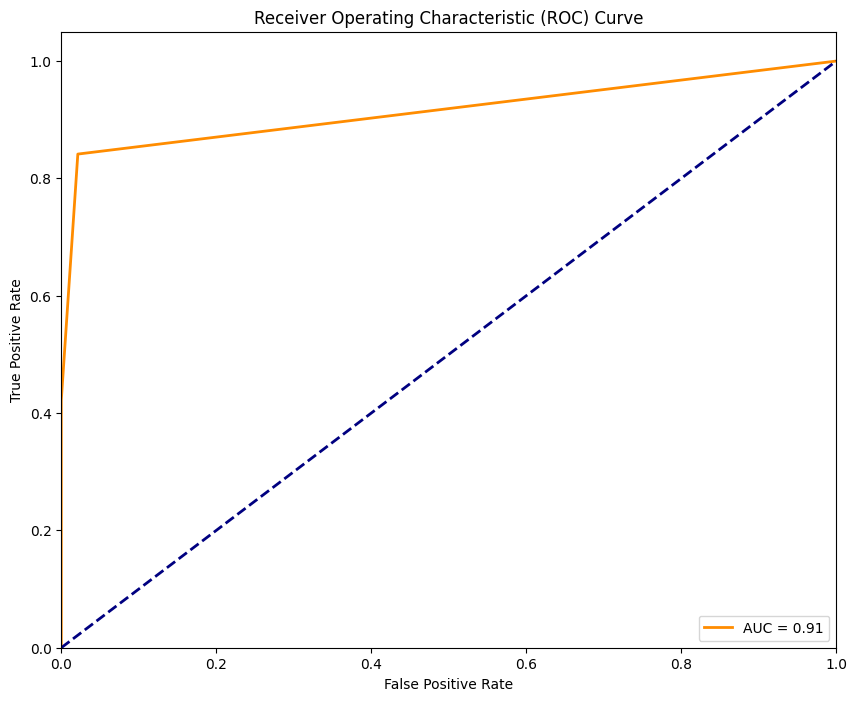

In [12]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve and AUC score
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Sample index for which you want to visualize the decision path
sample_index = 0

# Get the decision path for the sample
decision_path = clf.decision_path(X_test.iloc[[sample_index]])

# Extract feature indices from the decision path
feature_indices = decision_path.indices

# Extract the decision values from the decision path
node_values = decision_path.data

# Plot the decision path
plt.figure(figsize=(16, 6))
plt.imshow(node_values.reshape(1, -1), interpolation='none', cmap='viridis', aspect='auto')
plt.xticks(range(len(feature_indices)), X.columns[feature_indices], rotation=45, ha='right')
plt.yticks([0], [sample_index])
plt.title('Decision Path for Sample')
plt.xlabel('Feature')
plt.ylabel('Node')
plt.colorbar(label='Node Value', orientation='vertical')
plt.show()

## FOREST

In [ ]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42,criterion="gini",max_depth=5)

# Train the classifier on the training set
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Visualize each tree in the Random Forest
n_trees = len(rf_classifier.estimators_)
fig, axes = plt.subplots(nrows=1, ncols=n_trees, figsize=(4 * n_trees, 4), dpi=100)  # Adjust the figsize parameter

for i in range(n_trees):
    plot_tree(rf_classifier.estimators_[i], filled=True, feature_names=[f'feature_{i}' for i in range(X_train.shape[1])], class_names=['0', '1'], ax=axes[i])
    axes[i].set_title(f'Tree {i+1}')

plt.show()


In [ ]:
# Plot feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Get predicted probabilities for the positive class
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()